$\def \dot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \adot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \cD {\mathcal{D}}$
$\def \cW {\mathcal{W}}$
$\def \bc {\mathbf{c}}$
$\def \bv {\mathbf{v}}$
$\def \bG {\mathbf{G}}$

# A measurement-driven greedy algorithm

We have a solution $u$ (actually $u_h$, i.e. the solution of FEM here, but lets just assume it is ground truth here). 
We're given our measurement space $W_m = \mathrm{span}\{w_1,\ldots,w_m\}$. We have a series of measurements $\langle w_i, u\rangle_V$, and we write $w := P_{W_m} u$, the projection of $u$ in $W_m$.

This algorithm makes a very simple adjustment to the greedy algorithm - it does the argmax search in the $W_m$ projection. Of course as $n \to m$ there is nothing we can do about $\beta(V_n, W_m) \to 0$.

__Remarks:__
 - __Note that $\dot{\cdot}{\cdot} = \dot{\cdot}{\cdot}_{V_h}$ here.__
 - We can __assume that the $\omega_i$ are orthonormal__ as it is a fixed basis.
 - We store $\dot{\omega_i}{v}$ for each $v\in \cD$, so can we di all projections and inner-products in $\mathbb{R}^m$? And furthermore without the need of a Gram matrix $\dot{\phi_i}{\phi_j}$ to do the projection or orthonormalisation of $\phi_i$?
 - Finally, remember that _we can not know anything about $u$ other than $w :=P_{W_m} u$_, and we abuse notation slightly and also write $w=\dot{\omega_i}{u}$ for the vector in $\mathbb{R}^m$ (again, we assume the $\omega_i$ are orthonormal).
 
In the algorithms below we have some dictionary $\cD$ which we take to We have a dictionary $\cD$ of solutions $v(y)$, which we get from generating random points in $y\in[-1,1]^{d}$ ($d=16$ in the experiments below), find the field $a(y)$ and then $v(y) = \frac{u_h(a(y))}{\| u_h(a(y)) \|_{V_h}}$ (i.e. we normalise all elements). 

### Algorithm 1 - Pure Greedy

The first algorithm doesn't depend on $W_m$ at all. Given the dictionary $\cD$ we chose
$$
\phi_1 = {\arg\max}_{v\in\cD} \| v \|
$$
and given $V_{n}=\mathrm{span}\{\phi_1, \ldots, \phi_n\}$, our next choice is
$$
\phi_{n+1} = {\arg\max}_{v\in\cD} \| v - P_{V_n} v \|
$$

### Algorithm 2: Measurement based orthogonal matching pursuit

Now we only work with $w$ and $P_{W_m} v$, hence we can do all calculations in $\mathbb{R}^m$.

Once again the first element $\phi_1$ is chosen as 

$$ \phi_1 = {\arg\max}_{v\in \cD} \adot{w}{v}$$

and given our collection $V_{n}=\mathrm{span}\{\phi_1, \ldots, \phi_n\}$ we have that $P_{W_m} V_n = \mathrm{span}\{P_{W_m} \phi_1,\ldots,P_{W_m} \phi_n\}$, and our next choice is

$$ \phi_{n+1} = {\arg\max}_{v\in \cD} \adot{w - P_{P_{W_m} V_n} w}{\frac{P_{W_m} v}{\|P_{W_m} v\|}}$$

The calculation of $P_{P_{W_m} V_n} w$ is a straightforward solving of a linear problem. We have
$$
\dot{w}{P_{W_m} \phi_i} = \dot{P_{P_{W_m} V_n} w}{P_{W_m} \phi_i}
$$
and we have
$$
P_{P_{W_m} V_n} w = \sum_{i=1}^n c_i P_{W_m} \phi_i  %= \sum_{i=1}^n \sum_{j=1}^m c_i \dot{\omega_j}{\phi_i} \omega_j
$$
so clearly 

$$
\dot{w}{P_{W_m} \phi_j} = \sum_{i=1}^n c_i \dot{P_{W_m} \phi_j}{P_{W_m} \phi_i}.
$$

In addition to this we have that $w = \sum_{k=1}^{m} \dot{u}{\omega_k} \omega_k$ and $P_{W_m} \phi_i = \sum_{k=1}^m \dot{\phi_i}{\omega_k} \omega_k$, and $\dot{P_{W_m} \phi_i}{P_{W_m} \phi_j} = \sum_{k=1}^m \dot{\omega_k}{\phi_j} \dot{\omega_k}{\phi_i}$, hence we solve

$$
\sum_{k=1}^{m} \dot{u}{\omega_k} \dot{\phi_i}{\omega_k} = \sum_{j=1}^n c_j \sum_{k=1}^m \dot{\omega_k}{\phi_j} \dot{\omega_k}{\phi_i}
$$

### Algorithm 3: Measurement based projection pursuit

The first element $\phi_1$ is chosen as 

$$ \phi_1 = {\arg\min}_{v\in \cD} \| w - P_{P_{W_m} v} w \|.$$

we have $\| w - P_{P_{W_m} v} w \|^2 = \| w \|^2 - \| P_{P_{W_m} v} w \|^2 = \| w \|^2 - \frac{\dot{w}{P_{W_m} v}^2}{\dot{P_{W_m} v}{P_{W_m} v}^2} = \| w \|^2 - \frac{\dot{w}{v}^2}{\dot{P_{W_m} v}{P_{W_m} v}^2}$, we see that 
this is equivalent to

$$ \phi_1 = {\arg\max}_{v\in \cD} \frac{\adot{w}{v}}{\adot{P_{W_m} v}{P_{W_m} v}},$$

which again can be performed in $\mathbb{R}^m$.

Now given our collection $V_{n}=\mathrm{span}\{\phi_1, \ldots, \phi_n\}$ our next choice is

$$ \phi_{n+1} = {\arg\min}_{v\in \cD} \| w - P_{P_{W_m} (V_n\oplus \mathbb{R} v)} w \|$$

In terms of vectors $z \in \cW = \{ P_{W_m} \phi : \text{for } v \in \cD \}$ and the space $Z_n = P_{W_m} V_n = \mathrm{span}\{ P_{W_m} \phi_1,\ldots,P_{W_m}\phi_n\} = \mathrm{span}\{ z_1,\ldots,z_n\}$

$$
 z_{n+1} = {\arg\min}_{z\in\cW} \| w - P_{Z_n \oplus \mathbb{R}z} w \|
$$

which is also performed in $\mathbb{R}^m$, but now requires calculating projections for every single candidate vector from the dictionary.

In [2]:
import numpy as np
import scipy as sp
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

### Generate the solution $u$ that we want to approximate

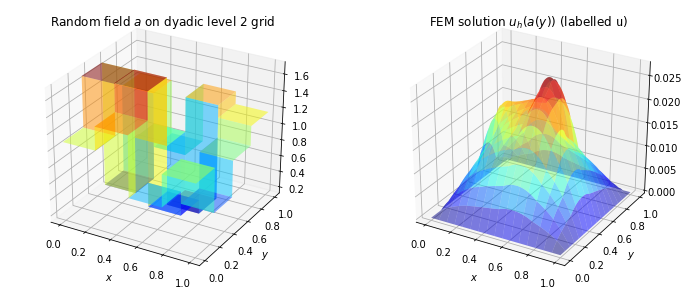

In [3]:
fem_div = 7

a_bar = 1.0
c = 0.9
field_div = 2
side_n = 2**field_div

np.random.seed(3)
point_gen = pat.MonteCarlo(d=side_n*side_n, n=1, lims=[-1, 1])
a = pat.PWConstantSqDyadicL2(a_bar + c * point_gen.points[0,:].reshape([side_n, side_n]), div=field_div)
fem = pat.DyadicFEMSolver(div=fem_div, rand_field=a, f=1.0)
fem.solve()

u = fem.u

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
a.plot(ax, title='Random field $a$ on dyadic level 2 grid')
ax = fig.add_subplot(1, 2, 2, projection='3d')
fem.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u}$)')
plt.show()

### Generate the basis $W_m$ of randomly placed local averages

m = 64


[]

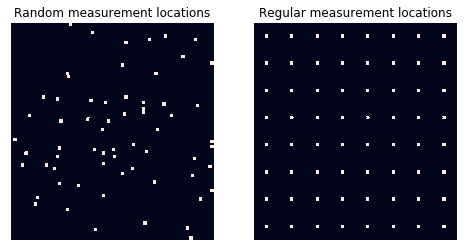

In [4]:
# local_width is the width of the measurement squares in terms of FEM mesh squares
width_div = 1
local_width = 2**width_div
spacing_div = 4

Wm_reg, Wloc_reg = pat.make_local_avg_grid_basis(width_div, spacing_div, fem_div, return_map=True)
Wm_reg = Wm_reg.orthonormalise()

m = Wm_reg.n
print('m =', m)

# We make the ambient spaces for Wm and Vn
np.random.seed(2)

Wm_rand, Wloc = pat.make_pw_local_avg_random_basis(m=m, div=fem_div, width=local_width, return_map=True)
Wm_rand = Wm_rand.orthonormalise()

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 1)
sns.heatmap(Wloc.values, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
ax.set_title('Random measurement locations')
ax = fig.add_subplot(1, 2, 2)
sns.heatmap(Wloc_reg.values, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
ax.set_title('Regular measurement locations')
plt.plot()

### Generate the dictionary of random snapshots

In [5]:
N = int(5e3)
np.random.seed(1)
dict_basis, dict_fields = pat.make_pw_reduced_basis(N, field_div, fem_div, a_bar=a_bar, c=c, f=1.0, verbose=False)
dictionary = dict_basis.vecs

In [6]:
Vn_sin = pat.make_pw_sin_basis(div=fem_div, N=8)
Vn_red, Vn_red_fields = pat.make_pw_reduced_basis(m, field_div, fem_div, a_bar=a_bar, c=c, f=1.0, verbose=False)

In [7]:
#bases = [Vn_sin, Vn_red]
#basis_labels = ['Sinusoid basis', 'Reduced basis']

g = pat.GreedyApprox(dictionary, Vn=pat.PWBasis(), verbose=True)
g.construct_to_n(m)

greedys = [g]

WmVn_pairs = []
WmVn_pair_labels = []
for Wm, Wm_label in zip([Wm_reg, Wm_rand], ['Reg grid', 'Random']):
    for Vn, Vn_label in zip([Vn_sin, Vn_red, g.Vn], ['Sinusoid basis', 'Reduced basis', 'Plain greedy']):
        label = 'Wm: ' + Wm_label + ', Vn: ' + Vn_label
        print(label)
        WmVn_pairs.append([Wm, Vn])
        WmVn_pair_labels.append(label)
    
    for alg, Vn_label in zip([pat.MeasBasedOMP, pat.MeasBasedPP], ['Meas based OMP', 'Meas based PP']):
        label = 'Wm: ' + Wm_label + ', Vn: ' + Vn_label
        print(label)
        cons = alg(dictionary, u, Wm, Vn=pat.PWBasis(), verbose=True)
        cons.construct_to_n(m)
        greedys.append(cons)
        WmVn_pairs.append([Wm, cons.Vn])
        WmVn_pair_labels.append(label)
        
print(WmVn_pair_labels)

i 	 Selection 	 Sel. criteria
1 : 	 25 	 1.0000000000000002
2 : 	 1320 		 0.79719177807292
3 : 	 1936 		 0.7689015261739112
4 : 	 2576 		 0.7524567008552325
5 : 	 2789 		 0.6993373106726762
6 : 	 2724 		 0.6683816189734256
7 : 	 740 		 0.656226376320557
8 : 	 4970 		 0.6339974370138128
9 : 	 3279 		 0.6174388997262812
10 : 	 881 		 0.6172896633688592
11 : 	 1132 		 0.5980515097356048
12 : 	 3667 		 0.5874066930445715
13 : 	 4728 		 0.5863513747501182
14 : 	 2208 		 0.5465758925488172
15 : 	 4477 		 0.536061648367949
16 : 	 27 		 0.5234781884632946
17 : 	 361 		 0.49175252879994363
18 : 	 3862 		 0.44371587102351373
19 : 	 4471 		 0.4398341261365973
20 : 	 3011 		 0.4386888420489206
21 : 	 995 		 0.4098899401144594
22 : 	 658 		 0.38772512336491455
23 : 	 2159 		 0.38083648397993985
24 : 	 1373 		 0.3713013498759541
25 : 	 2613 		 0.360376063001078
26 : 	 3682 		 0.3477774067366028
27 : 	 3244 		 0.33990556284960977
28 : 	 4077 		 0.3376926768092321
29 : 	 2520 		 0.31038506877989225
30

36 : 	 3667 		 6.48234949762124e-06
37 : 	 693 		 2.227866771441965e-06
38 : 	 2613 		 2.117336053143586e-06
39 : 	 3342 		 2.850402838738496e-06
40 : 	 2840 		 1.2343633837721741e-06
41 : 	 2503 		 1.2395490134417488e-06
42 : 	 2789 		 8.349321899004744e-07
43 : 	 1994 		 6.555965302598765e-07
44 : 	 1373 		 8.331389278883713e-07
45 : 	 77 		 6.16152058522101e-07
46 : 	 2825 		 3.9527570608234517e-07
47 : 	 1052 		 2.4638804764435346e-07
48 : 	 1817 		 3.296754825318649e-07
49 : 	 2576 		 1.2485147659512674e-07
50 : 	 1268 		 1.0337310899757421e-07
51 : 	 15 		 5.2094144474438436e-08
52 : 	 1632 		 5.476450073784942e-08
53 : 	 3645 		 5.284550654079798e-08
54 : 	 497 		 5.719457362909239e-08
55 : 	 2886 		 2.5128973639382126e-08
56 : 	 687 		 1.0900808571692544e-08
57 : 	 1320 		 1.2175568200151487e-08
Vn spans all dictionary points at n=57, stopping greedy
Done!
Wm: Random, Vn: Meas based PP
i 	 Selection 	 Sel. criteria
1 : 	 4422 	 0.054569234095847505
2 : 	 2555 		 0.0062023423798

In [8]:
stats = np.zeros([6, len(WmVn_pairs), m])

for j, pair in enumerate(WmVn_pairs):
    Wm = pair[0]
    Vn_big = pair[1].orthonormalise()
    label = WmVn_pair_labels[j]

    print('Reconstructions for pair: ' + label)
    for i, n in enumerate(range(2,min(Vn_big.n, m))):
        
        Vn = Vn_big.subspace(slice(0,n))
        u_p_v = Vn.project(u)
        BP = pat.BasisPair(Wm, Vn)
        #FB = BP.make_favorable_basis()
        u_star, v_star, w_p, v_w_p, cond = BP.measure_and_reconstruct(u)

        stats[0, j, n] = (u-u_star).norm()
        stats[1, j, n] = (u_star - v_star).norm()
        stats[2, j, n] = BP.beta()
        stats[3, j, n] = cond
        stats[4, j, n] = (u - u_p_v).norm()

Reconstructions for pair: Wm: Reg grid, Vn: Sinusoid basis
Reconstructions for pair: Wm: Reg grid, Vn: Reduced basis
Reconstructions for pair: Wm: Reg grid, Vn: Plain greedy
Reconstructions for pair: Wm: Reg grid, Vn: Meas based OMP
Reconstructions for pair: Wm: Reg grid, Vn: Meas based PP
Reconstructions for pair: Wm: Random, Vn: Sinusoid basis
Reconstructions for pair: Wm: Random, Vn: Reduced basis
Reconstructions for pair: Wm: Random, Vn: Plain greedy
Reconstructions for pair: Wm: Random, Vn: Meas based OMP
Reconstructions for pair: Wm: Random, Vn: Meas based PP


5


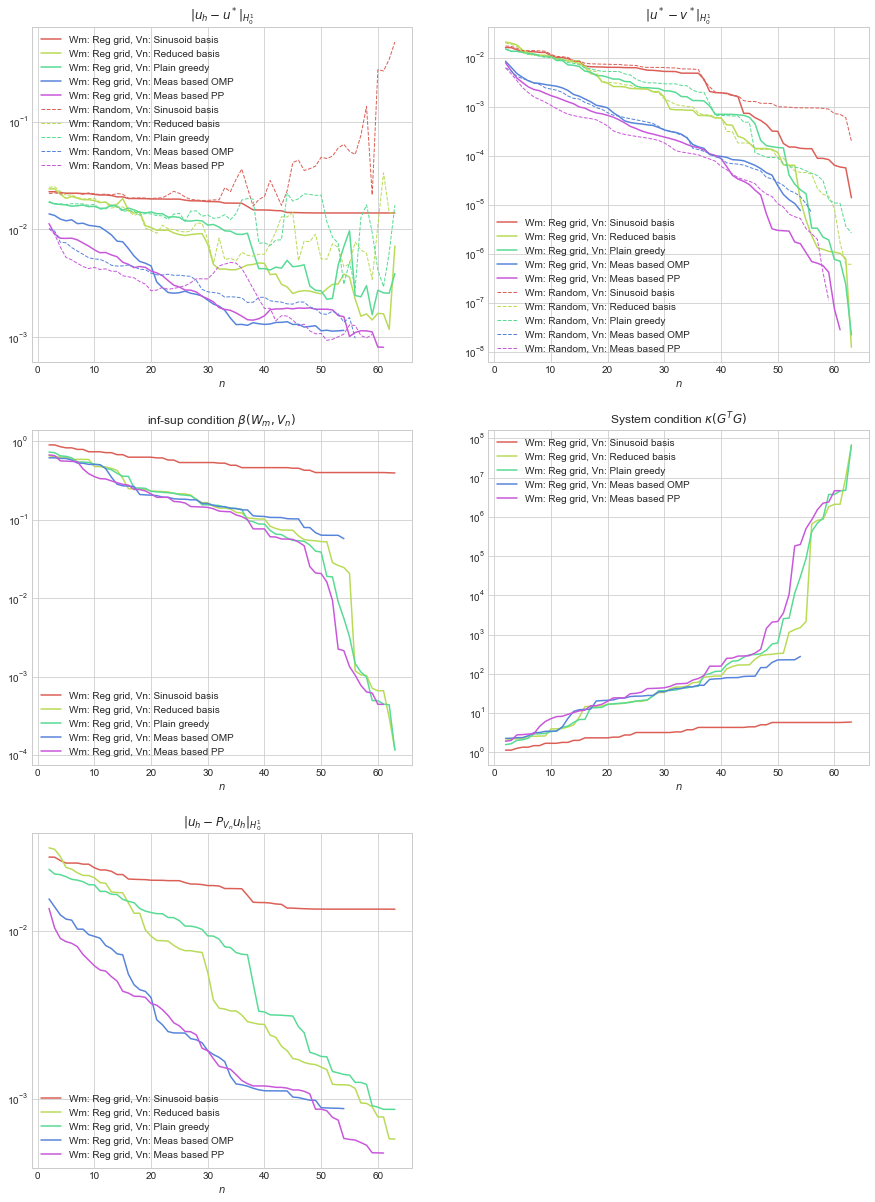

In [9]:
num_res = len(WmVn_pairs)//2
print(num_res)
sns.set_palette('hls', num_res)
cp = sns.color_palette()
sns.set_style('whitegrid')

axs = []
fig = plt.figure(figsize=(15, 21))
axs.append(fig.add_subplot(3, 2, 1, title='$\| u_h - u^* \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 2, title='$\| u^* - v^* \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 3, title=r'inf-sup condition $\beta(W_m, V_n)$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 4, title=r'System condition $\kappa(G^T G)$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 5, title='$\| u_h - P_{V_n} u_h \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')


for j, basis_label in enumerate(WmVn_pair_labels[:num_res]):
    
    axs[0].plot(range(2, WmVn_pairs[j][1].n), stats[0, j, 2:WmVn_pairs[j][1].n], label=basis_label, color=cp[j])
    axs[0].legend(loc=0)
    axs[1].plot(range(2, WmVn_pairs[j][1].n), stats[1, j, 2:WmVn_pairs[j][1].n], label=basis_label, color=cp[j])
    axs[1].legend(loc=3)
    axs[2].plot(range(2, WmVn_pairs[j][1].n), stats[2, j, 2:WmVn_pairs[j][1].n], label=basis_label, color=cp[j])
    axs[2].legend(loc=3)
    axs[3].plot(range(2, WmVn_pairs[j][1].n), stats[3, j, 2:WmVn_pairs[j][1].n], label=basis_label, color=cp[j])
    axs[3].legend(loc=2)
    axs[4].plot(range(2, WmVn_pairs[j][1].n), stats[4, j, 2:WmVn_pairs[j][1].n], label=basis_label, color=cp[j])
    axs[4].legend(loc=3)

for j, basis_label in enumerate(WmVn_pair_labels[num_res:]):

    axs[0].plot(range(2, WmVn_pairs[j+num_res][1].n), stats[0, j+num_res, 2:WmVn_pairs[j+num_res][1].n], '--', lw=1, label=basis_label, color=cp[j])
    axs[0].legend(loc=0)
    axs[1].plot(range(2, WmVn_pairs[j+num_res][1].n), stats[1, j+num_res, 2:WmVn_pairs[j+num_res][1].n], '--', lw=1, label=basis_label, color=cp[j])
    axs[1].legend(loc=3)
plt.savefig('GreedyMeasSelectionResults.pdf')
plt.show()

### Lets see _where_ these points are chosen to be - right now our best bet is to do a pair grid to reduce to combinations of 2d plots

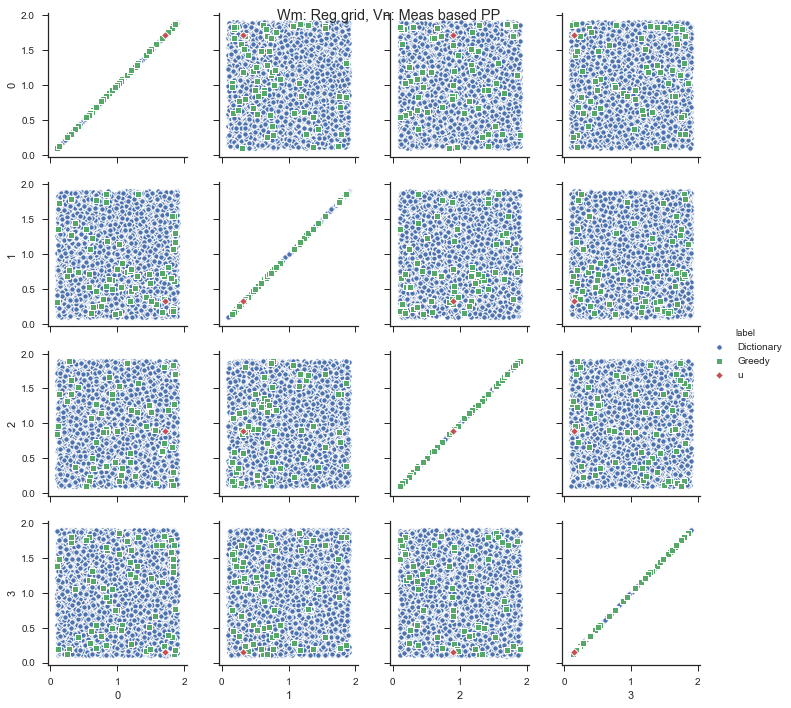

In [10]:
import pandas as pd

sns.set(style="ticks")

dict_values = np.zeros((len(dict_fields), np.product(dict_fields[0].values[1:3,1:3].shape)))

for i, v in enumerate(dict_fields):
    dict_values[i,:] = v.values[1:3,1:3].flatten()

dict_df = pd.DataFrame(dict_values)
dict_df['label'] = 'Dictionary'

#for greedy in greedys:
greedy_idx = 2
greedy = greedys[greedy_idx]
label = WmVn_pair_labels[greedy_idx+2]

# We plot arbitrary sub-axes in one of those multivariate griddy plot things yay.
greedy_sel_df = pd.DataFrame(dict_values[greedy.dict_sel])
greedy_sel_df['label'] = 'Greedy'
dict_df = dict_df.append(greedy_sel_df)

u_df = pd.DataFrame(a.values[1:3,1:3].reshape((1,4)))
u_df['label'] = 'u'
dict_df = dict_df.append(u_df)


#sns.PairGrid(dict_df)
g = sns.PairGrid(dict_df, hue="label", hue_kws={"marker": ["o", "s", "D"]})
g = g.map(plt.scatter, linewidths=1, edgecolor="w", s=30)
g = g.add_legend()
g.fig.suptitle(label)

### Lets look at the distances in $H^1_0$ between $u$ and $\phi_1,\phi_2,...$

Though this doesn't really tell us all that much

Wm: Reg grid, Vn: Sinusoid basis
Wm: Reg grid, Vn: Reduced basis
Wm: Reg grid, Vn: Plain greedy
Wm: Reg grid, Vn: Meas based OMP
Wm: Reg grid, Vn: Meas based PP


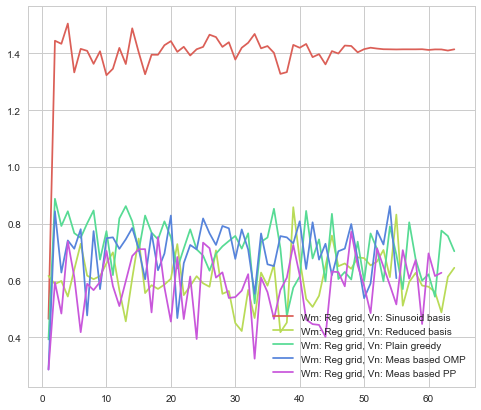

In [11]:
sns.set_palette('hls', 5)
cp = sns.color_palette()
sns.set_style('whitegrid')

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(1,1,1)

for j, basis_label in enumerate(WmVn_pair_labels[:5]):
    
    axs[0].plot(range(2, WmVn_pairs[j][1].n), stats[0, j, 2:WmVn_pairs[j][1].n], label=basis_label, color=cp[j])
    axs[0].legend(loc=0)

u_norm = u / u.norm()
Vn_dists = np.zeros((len(WmVn_pairs[:5]), m))
for j, (WmVnPair, label) in enumerate(zip(WmVn_pairs[:5], WmVn_pair_labels[:5])):
    print(label)
    Vn = WmVnPair[1]
    for i, v in enumerate(Vn.vecs):
        Vn_dists[j,i] = (v - u_norm).norm()
    ax.plot(np.arange(1,Vn.n+1), Vn_dists[j,:Vn.n], label=label)
plt.legend()
plt.show()

### Use tSNE to learn a 2d embedding in which the distribution of distances in the 2d space is as close as possible to the higher dimensional space

In [12]:
dict_basis.make_grammian()

In [13]:
dist_sq = 2.0*(1.0 - dict_basis.G)
dist_sq[dist_sq < 0.0] = 0.0
dist = np.sqrt(dist_sq)

In [14]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dist)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 1.507s...
[t-SNE] Computed neighbors for 5000 samples in 238.549s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.835925
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.653267
[t-SNE] Error after 300 iterations: 3.045734


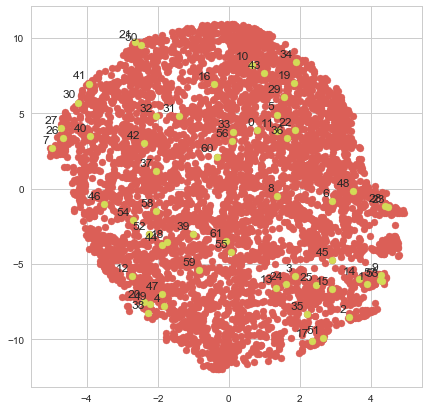

In [15]:
sns.set_palette('hls')
sns.set_style('whitegrid')

fig = plt.figure(figsize=(7,7))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], marker='o')


greedy = greedys[2]

labels = ['{0}'.format(j) for j in range(greedy.n)] 

plt.scatter(tsne_results[greedy.dict_sel, 0], tsne_results[greedy.dict_sel, 1], marker='o')

for label, x, y in zip(labels, tsne_results[greedy.dict_sel, 0], tsne_results[greedy.dict_sel, 1]):
    plt.annotate(
        label, xy=(x, y), xytext=(-3, 3), textcoords='offset points', ha='right', va='bottom')



In [16]:
tsne_results

array([[ 0.5101452 , -3.8399715 ],
       [-1.1202846 , -3.926808  ],
       [-1.1104879 , -8.11945   ],
       ...,
       [-0.08028533,  4.6170316 ],
       [ 3.47402   ,  1.4985588 ],
       [-0.9109612 , -9.242318  ]], dtype=float32)